### Import Packages

SKLearn library forces depreciation warnings which have no effect on the reliability of the project, so these will be silenced here

In [28]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [29]:
import numpy as np
import pandas as pd

# machine learning specific functions
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

%store -r df

### Perform Model

#### Create Validation Dataset

In [30]:
# get classifier values (online, offline)
y = df['status'].values

# get station name values
X1 = df['station_name']

# get all values that are after the status (timing information and prediction values)
status_index = df.columns.get_loc('status')
X2 = df.iloc[:, status_index + 1:]

# combine X1 and X2
X_total = pd.concat([X1, X2], axis=1)
X = X_total.values

# feature selection SectKBest method
selector = SelectKBest()
X = selector.fit_transform(X, y)

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=7)

X_train = X_train.astype('float')
X_validation = X_validation.astype('float')
y_train = y_train
y_validation = y_validation

In [31]:
columns_all = list(X_total)
columns = selector.get_support(indices=True)

for col in columns:
    print(columns_all[col])

humidity_t-1
humidity_t-2
barometric_pressure_t-1
barometric_pressure_t-2
barometric_pressure_t-3
barometric_pressure_t-4
battery_life_t-1
battery_life_t-2
battery_life_t-3
battery_life_t-4


#### Assign Models that should be tested

In [32]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

#### Evaluate Each Model

In [33]:
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.948443 (0.002610)
LDA: 0.926738 (0.002471)
KNN: 0.945589 (0.002657)
CART: 0.905964 (0.003714)
NB: 0.855973 (0.001610)


#### Compare Algorithms

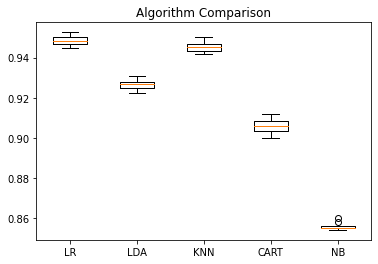

In [34]:
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

#### Choose Model with highest Precision

In [35]:
max_prec = 0

for index in range(0, len(models)):
    prec = results[index].mean()

    if prec > max_prec:
        max_prec = prec
        model = models[index]

print('Algorithm ' + model[0] + ' scored highest precision')

# model consists of tuple with name
model = model[1]

Algorithm LR scored highest precision


#### Fit selected Model

In [36]:
model.fit(X_train, y_train)
predictions = model.predict(X_validation)

#### Evaluate Predictions 

Total Accuracy Score

In [37]:
print(accuracy_score(y_validation, predictions))

0.9521128993895187


Classification Report

In [38]:
cr = classification_report(y_validation, predictions)
print(cr)

              precision    recall  f1-score   support

     offline       0.75      0.27      0.40       737
      online       0.96      0.99      0.98     11876

    accuracy                           0.95     12613
   macro avg       0.85      0.63      0.69     12613
weighted avg       0.94      0.95      0.94     12613



Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

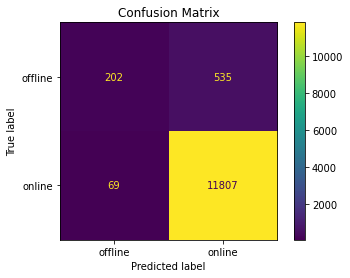

In [42]:
cm = confusion_matrix(y_validation, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
pyplot.title("Confusion Matrix")

Online versus Offline Prediction

[Text(0, 0, '0.75'), Text(0, 0, '0.96')]

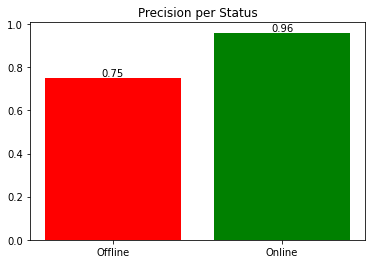

In [40]:
precision_status = cm.diagonal() / cm.sum(axis=0)
precision_status = np.round(precision_status, 2)
bar = pyplot.bar(["Offline", "Online"], precision_status, color=["red", "green"])
pyplot.title("Precision per Status")
pyplot.bar_label(bar, precision_status)
   